# The Plesser Problem

<img src="plesser-problem.png" width="300"/>

In [1]:
import math
import copy
import IPython
import networkx as nx
import matplotlib.pyplot as plt

from plesser_utils import draw_node_edges, get_pairs, reverse_destination_order

In [2]:
starting_node_edges = [
    ('w1', ['e1', 'b1', 'b8']), ('w2', ['b1', 'b2', 'b3']), ('w3', ['b2', 'b4', 'b3']), ('w4', ['b4', 'e5', 'b5']),
    ('w5', ['b3', 'b5', 'w7']), ('w6', ['b5', 'e6', 'b6']), ('w7', ['w5', 'b6', 'b8']), ('w8', ['b6', 'e7', 'b7']),
    ('b1', ['e2', 'w2', 'w1']), ('b2', ['e3', 'w3', 'w2']), ('b3', ['w3', 'w5', 'w2']), ('b4', ['e4', 'w4', 'w3']),
    ('b5', ['w4', 'w6', 'w5']), ('b6', ['w6', 'w8', 'w7']), ('b7', ['w8', 'e8', 'b8']), ('b8', ['w7', 'b7', 'w1'])
]

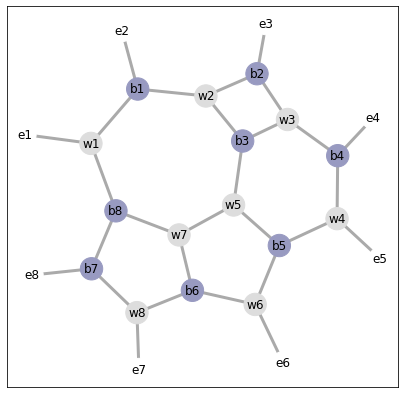

In [3]:
IPython.display.display(IPython.display.HTML('<h1>Starter graph</h1>'))
IPython.display.display(IPython.display.HTML('<img src="starter_graph.png" width="390"/>'))
draw_node_edges(starting_node_edges)

In [4]:
solution_node_edges = [
    ('w1', ['e3', 'b2', 'b1']), ('w2', ['b2', 'b3', 'b4']), ('w3', ['b3', 'w4', 'b4']), ('w4', ['w3', 'e6', 'w5']),
    ('w5', ['w4', 'b6', 'b5']), ('w6', ['b4', 'b5', 'b8']), ('w7', ['b5', 'b6', 'b7']), ('w8', ['b8', 'b7', 'e1']),
    ('b1', ['e2', 'w1', 'b8']), ('b2', ['e4', 'w2', 'w1']), ('b3', ['e5', 'w3', 'w2']), ('b4', ['w2', 'w3', 'w6']),
    ('b5', ['w5', 'w7', 'w6']), ('b6', ['e7', 'w7', 'w5']), ('b7', ['e8', 'w8', 'w7']), ('b8', ['w6', 'w8', 'b1'])
]

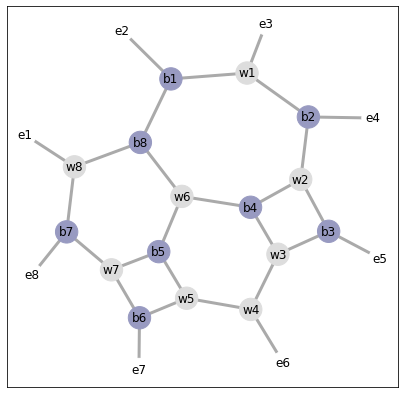

In [5]:
IPython.display.display(IPython.display.HTML('<h1>Solution graph</h1>'))
IPython.display.display(IPython.display.HTML('<img src="solution_graph.png" width="390"/>'))
draw_node_edges(solution_node_edges)

In [16]:
class Graph:
    
    def __init__(self, node_edges, previous_graphs=[], previous_moves=['Starter graph'], depth=0):
        self.node_edges = copy.deepcopy(node_edges)
        self.depth = depth
        self.previous_graphs = previous_graphs + [self]
        self.previous_moves = previous_moves
    
    def draw(self):
        draw_node_edges(self.node_edges)
        
    # Find all pairs of same-color touching nodes
    def get_duo_moves(self):
        duo_moves = []
        for node, destinations in self.node_edges:
            for destination in destinations:
                if node[0] == destination[0] and (destination, node) not in duo_moves:
                    duo_moves.append((node, destination))
        return duo_moves
        
    # Find all quads of alternate-colored squares
    def get_quad_moves(self):
        quad_moves = []
        
        potentials = []
        for node, destinations in self.node_edges:
            if node[0] == 'w':
                black_destinations = list(filter(lambda x: x[0] == 'b', destinations))
                black_pairs = get_pairs(black_destinations)
                for black_pair in black_pairs:
                    potentials.append((node, black_pair))
        
        for i in range(len(potentials)):
            white_node1, black_pair1 = potentials[i]
            for j in range(i + 1, len(potentials)):
                white_node2, black_pair2 = potentials[j]
                if black_pair1 == black_pair2:
                    quad_moves.append((white_node1, black_pair1[0], white_node2, black_pair1[1]))
        
        return quad_moves
            
    def execute_duo_move(self, node1, node2):
        new_node_edges = copy.deepcopy(self.node_edges)
        node_edge1 = list(filter(lambda x: x[0] == node1, self.node_edges))[0]
        node_edge2 = list(filter(lambda x: x[0] == node2, self.node_edges))[0]
        index1 = (node_edge1[1].index(node2) + 1) % len(node_edge1[1])
        index2 = (node_edge2[1].index(node1) + 1) % len(node_edge2[1])
        prev_destination1 = node_edge1[1][index1]
        prev_destination2 = node_edge2[1][index2]
        for i, (node, destinations) in enumerate(new_node_edges):
            if node == node1:
                destinations[index1] = prev_destination2
                new_node_edges[i] = (node, reverse_destination_order(destinations))
            if node == node2:
                destinations[index2] = prev_destination1
                new_node_edges[i] = (node, reverse_destination_order(destinations))
            if node == prev_destination1:
                index = destinations.index(node1)
                new_node_edges[i][1][index] = node2
            if node == prev_destination2:
                index = destinations.index(node2)
                new_node_edges[i][1][index] = node1
                
        return Graph(
            new_node_edges, 
            self.previous_graphs,
            self.previous_moves + ['Duo move with {} and {}'.format(node1, node2)],
            self.depth + 1
        )
    
    def execute_quad_move(self, node1, node2, node3, node4):
        new_node_edges = copy.deepcopy(self.node_edges)
        for i, (node, destinations) in enumerate(new_node_edges):
            if node == node1:
                new_node_edges[i] = (node4, destinations)
            elif node == node2:
                new_node_edges[i] = (node1, destinations)
            elif node == node3:
                new_node_edges[i] = (node2, destinations)
            elif node == node4:
                new_node_edges[i] = (node3, destinations)
            for j, destination in enumerate(destinations):
                if destination == node1:
                    new_node_edges[i][1][j] = node4
                elif destination == node2:
                    new_node_edges[i][1][j] = node1
                elif destination == node3:
                    new_node_edges[i][1][j] = node2
                elif destination == node4:
                    new_node_edges[i][1][j] = node3
                    
        return Graph(
            new_node_edges, 
            self.previous_graphs, 
            self.previous_moves + ['Quad move with {}, {}, {}, and {}'.format(node1, node2, node3, node4)],
            self.depth + 1
        )
    
    def execute_all_moves(self):
        for previous_graph in self.previous_graphs[:-1]:
            if self == previous_graph:
                return []
            
        new_graphs = []
        duos = self.get_duo_moves()
        quads = self.get_quad_moves()
        for duo in duos:
            new_graphs.append(self.execute_duo_move(*duo))
        for quad in quads:
            new_graphs.append(self.execute_quad_move(*quad))
            
        return new_graphs
    
    def __hash__(self):
        
        path = ['e1']
        
        queue = []
        
        node_edge_index = None
        destination_index = None
        for i, (node, destinations) in enumerate(self.node_edges):
            if 'e1' in destinations:
                node_edge_index = i
                destination_index = destinations.index('e1')
                path.append(node)
                queue.append((node, 'e1'))
                
        while len(path) < 24:
            
            node, origin = queue.pop(0)
            destinations = list(filter(lambda x: x[0] == node, self.node_edges))[0][1]
            origin_index = destinations.index(origin)
            for i in range(1, len(destinations)):
                destination_index = (origin_index + i) % len(destinations)
                destination = destinations[destination_index]
                if destination not in path:
                    path.append(destination)
                    if destination[0] != 'e':
                        queue.append((destination, node))
        
        hash_string = ''
        for node in path:
            if node[0] == 'e':
                hash_string += node
            else:
                hash_string += node[0]
        
        return hash(hash_string)
    
    def __eq__(self, other):
        if isinstance(other, Graph):
            return hash(self) == hash(other)
        return False

In [17]:
node_edges = [
    ('w1', ['e1', 'b1', 'b8']), ('w2', ['b1', 'b2', 'b3']), ('w3', ['b2', 'b4', 'b3']), ('w4', ['b4', 'e5', 'b5']),
    ('w5', ['b3', 'b5', 'w7']), ('w6', ['b5', 'e6', 'b6']), ('w7', ['w5', 'b6', 'b8']), ('w8', ['b6', 'e7', 'b7']),
    ('b1', ['e2', 'w2', 'w1']), ('b2', ['e3', 'w3', 'w2']), ('b3', ['w3', 'w5', 'w2']), ('b4', ['e4', 'w4', 'w3']),
    ('b5', ['w4', 'w6', 'w5']), ('b6', ['w6', 'w8', 'w7']), ('b7', ['w8', 'e8', 'b8']), ('b8', ['w7', 'b7', 'w1'])
]

In [18]:
target = Graph(solution_node_edges)
queue = [Graph(starting_node_edges)]
solution = None

print('Solving...')

while True:
    
    graph = queue.pop(0)
    
    if graph == target:
        solution = graph
        break
        
    queue += graph.execute_all_moves()

print('Solved.')

Solving...
Solved.


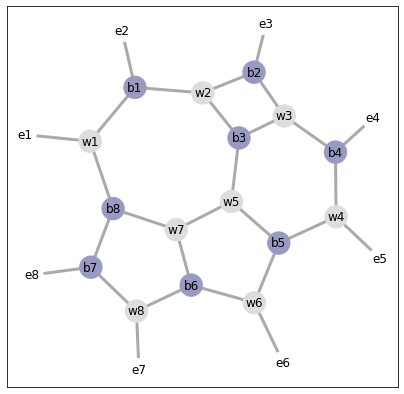

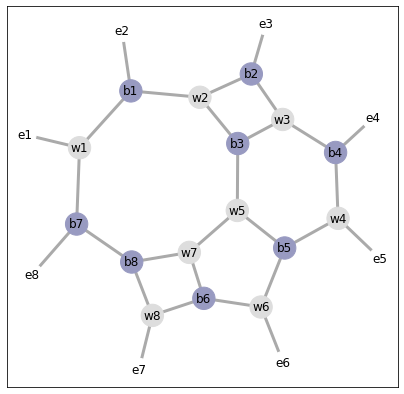

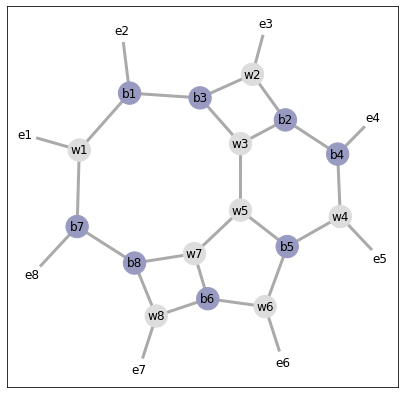

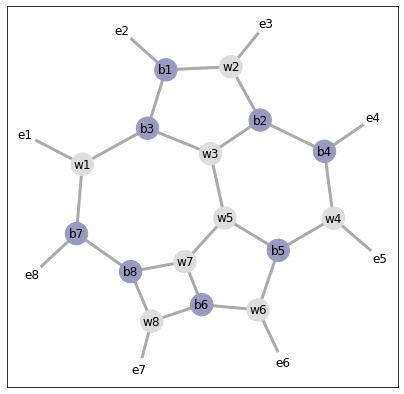

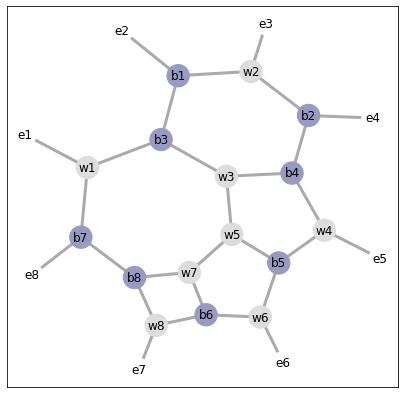

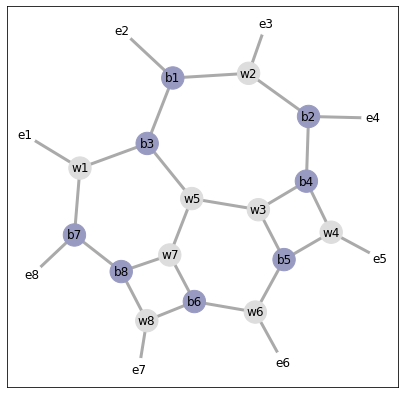

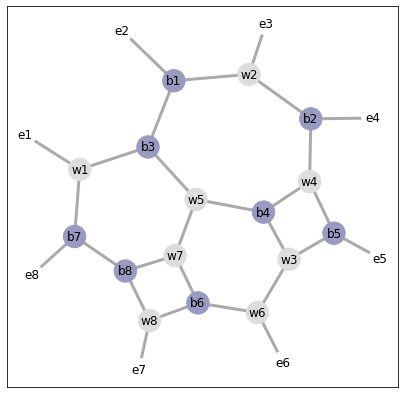

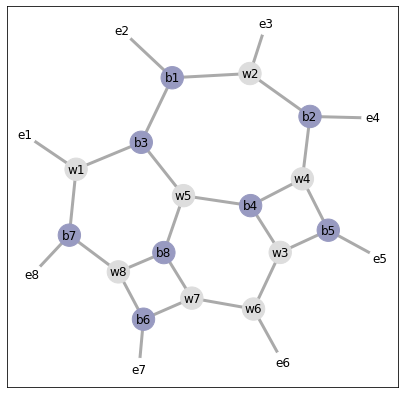

In [19]:
IPython.display.display(IPython.display.HTML('<h1>Starter graph</h1>'))
IPython.display.display(IPython.display.HTML('<img src="starter_graph.png" width="390"/>'))
for i, graph in enumerate(solution.previous_graphs):
    IPython.display.display(IPython.display.HTML('<h1>Step {}: {}</h1>'.format(i + 1, graph.previous_moves[i])))
    graph.draw()
IPython.display.display(IPython.display.HTML('<h1>Solution graph</h1>'))
IPython.display.display(IPython.display.HTML('<img src="solution_graph.png" width="390"/>'))